### Домашнее задание 3. Реализация простой Lambda-архитектуры хранилища.

В данной работе вам необходимо реализовать комплексный ETL-процесс. Ниже приложена его архитектурная схема.
Для решения необходимо использовать знакомые вам инструменты:
1. Spark DataFrame API/Spark Structured Streaming
2. Apache Minio - как хранилище
3. Apache Kafka - как шину данных
4. Apache Cassandra - как сервисную базу данных

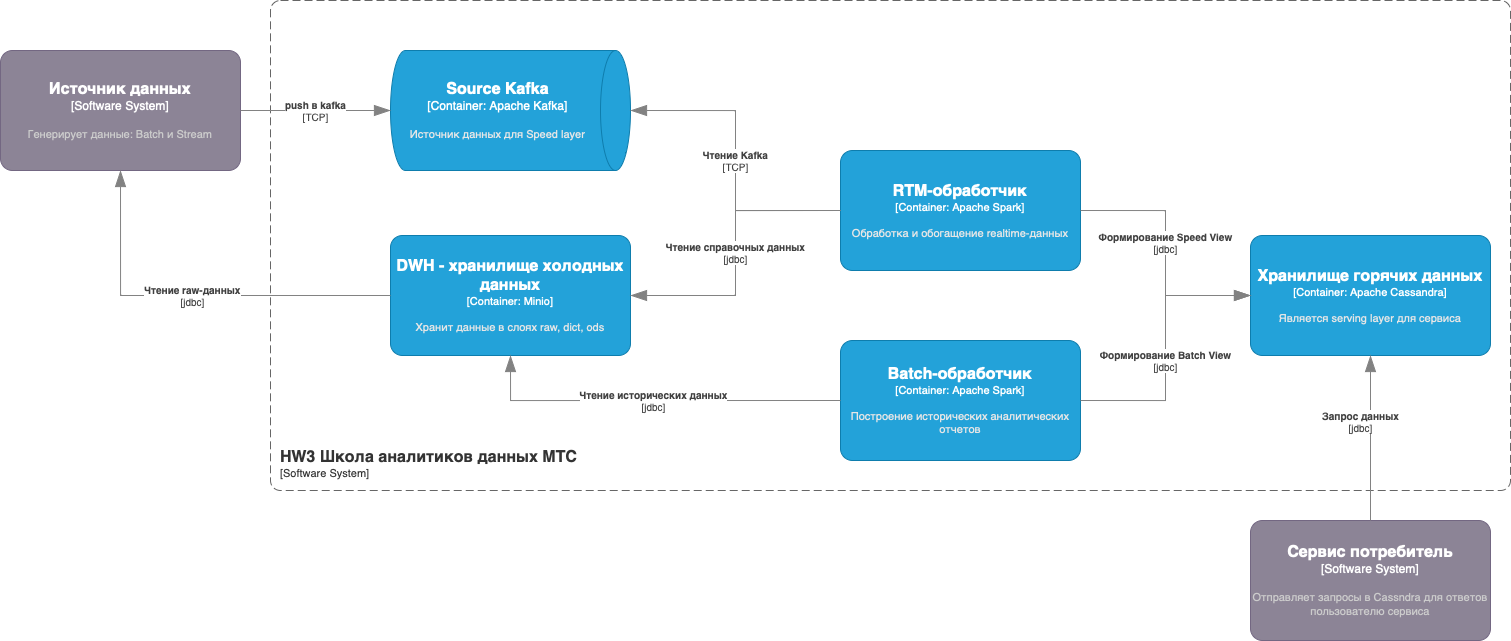

In [1]:
from IPython.display import Image
Image(filename='/hw3/ArchSchema-2.png')

#### Основные переменные и создание spark-сессии

In [2]:
CASSANDRA_IP = "172.18.0.6"

MINIO_URL = "http://minio:9000"
MINIO_ACCES_KEY = "2iQPJo6kPmG5gljzgA2m"
MINIO_SECRET_KEY = "8Dajh08V8ut2WaJRf0W5ueDAnaODlcpCoidbOxAW"


JAVA_REQUIREMENTS = ",".join([
    "org.apache.hadoop:hadoop-aws:3.3.2",
    "com.amazonaws:aws-java-sdk-pom:1.12.365",
    "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0",
    "com.datastax.spark:spark-cassandra-connector_2.12:3.5.0",
])

Для подключения к Cassandra, вам необходимо получить её ip-адресс из контейнера. Сделать это можно следующей командой:
`docker inspect <cassandra_container_name> | grep ip`

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [4]:
# параметры spark-сессии, которые необходимы для выполнения работы

spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("sykorole_test") \
    .config("spark.sql.adaptive.enabled", False) \
    .config("spark.executor.memory", "450M") \
    .config("spark.driver.memory", "450M") \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.sql.sources.bucketing.enabled", True) \
    .config('spark.jars.packages', JAVA_REQUIREMENTS) \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider') \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.access.key", MINIO_ACCES_KEY) \
    .config("spark.hadoop.fs.s3a.secret.key", MINIO_SECRET_KEY) \
    .config("spark.hadoop.fs.s3a.endpoint", MINIO_URL) \
    .config("spark.cassandra.connection.host", CASSANDRA_IP) \
    .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-42221fcd-3c47-465a-b386-a6602c010531;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found com.amazonaws#aws-java-sdk-pom;1.12.365 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central

#### Примеры полезного кода

In [5]:
# подключение к Cassandra через python client
from cassandra.cluster import Cluster

cluster = Cluster([CASSANDRA_IP])
session = cluster.connect()

In [6]:
session.execute("CREATE KEYSPACE IF NOT EXISTS hw_3 WITH replication = {'class': 'SimpleStrategy','replication_factor': 3}")

In [7]:
row = session.execute("describe keyspaces")

for i in row.all():
    print(i)

Row(keyspace_name='hw_3', type='keyspace', name='hw_3')
Row(keyspace_name='system', type='keyspace', name='system')
Row(keyspace_name='system_auth', type='keyspace', name='system_auth')
Row(keyspace_name='system_distributed', type='keyspace', name='system_distributed')
Row(keyspace_name='system_schema', type='keyspace', name='system_schema')
Row(keyspace_name='system_traces', type='keyspace', name='system_traces')
Row(keyspace_name='system_views', type='keyspace', name='system_views')
Row(keyspace_name='system_virtual_schema', type='keyspace', name='system_virtual_schema')


**Подготовка датафрейма currency**

In [8]:
# !pip install boto3

In [9]:
import boto3
from botocore.client import Config

# Создание клиента Minio
s3 = boto3.client('s3',
                  endpoint_url=MINIO_URL,
                  aws_access_key_id=MINIO_ACCES_KEY,
                  aws_secret_access_key=MINIO_SECRET_KEY,
                  config=Config(
                      signature_version='s3v4'))

# Получение списка бакетов
buckets = s3.list_buckets()
print("Доступные бакеты:", [bucket['Name'] for bucket in buckets['Buckets']])

Доступные бакеты: ['dict', 'ods', 'raw']


In [10]:
df_currencies = spark.read.orc("s3a://dict/currency/")

24/08/13 13:27:34 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


**Подготовка датафрейма flights**

In [11]:
from pyspark.sql import DataFrame

def load_data(year: int, month: int) -> DataFrame:
    return spark.read.format("orc") \
                .load(f"s3a://raw/flights/business_month={year}-{month}/part-00000-c7d64d19-7123-4cd8-afee-b032a816fc27.c000.snappy.orc")

In [12]:
df_months = []

for year in [2022, 2023]:
    for month in list(range(1, 13)):
        df_month = load_data(year, month)
        df_months.append(df_month)

df_flights = df_months[0]
for df in df_months[1:]:
    df_flights = df_flights.union(df)

print("Прочитано строк:", df_flights.count())

Прочитано строк: 1000000


### Что нужно сделать?

**1. Разведочный анализ (EDA) имеющихся данных**

Данные интеграции были настроены вашим коллегами из внешней для вас системы.

Необходимо рассмотреть данные в Minio и Kafka. Описать какие проблемы с данными и/или их хранением существуют (если есть). Предложить возможные решения.


 **2. Обработка near realtime потока данных tickets**

Для решения необходимо использовать Spark Structured Streaming для чтения Kafka (топик `tickets_topic`)

2.1. Настроить чтение данных с приведением стоимости проданных билетов к **базовой валюте**. Информацию о курсе можете взять из справочника **currency**

2.2. Подсчитать отставание данных:
- для сравнения использовать timestamp из топика Kafka
- отставание выражено в сутках
- исключить данные глубиной больше 14 дней

2.3. Реализовать поточную трансформацию:
- выручка каждой авиакомпании за поступающий микробатч
- размер окна - 5 минут

**Важно**: 
- все дробные данные должны округляться до сотых
- вывести результат команды `explain` в ячейку перед запуском (start) стриминга
- конечный результат должен поточно сохраняться в Cassandra (таблицу необходимо создать самостоятельно)
- результат (топ-10 строк) также обязательно выводится в ячейку с помощью запроса к БД (не через spark)

**3. Батчевая обработка сырых данных. Таблица flights**

3.1. В какие города летают авиакомпании?:
- Сформировать список городов
- Посчитать их количество 

3.2. Построить отчет по авиапарку компаний за 2023 год: 
- для каждой компании подсчитайте количество самолетов каждой категории
- совокупную вместимость за год (максимальное количество, которое можно перевести за год)
- среднюю вместимость
- допущение: 1 рейс = 1 самолет (они не чередуются между рейсами)

3.3. Найти топ-5 авиакомпаний с наименьшим средним временем полета:
- реализовать описанную трансформацию
- учесть проведенный в п.1 EDA

3.4. Построить отчет по количеству перевезенных пассажиров за каждый квартал 2022 и 2023 года: 
- сколько пасажиров авиакомпании могут перевезти за конкретный квартал в разрезе каждой компании
- посчитать изменение в процентах от квартала к кварталу (необходимо использовать оконные функции)
- проведите сортировку по количеству пассажиров по убыванияю

**(!)** Две из 4-х таблиц необходимы для реализации блока #4 (нужно понять какие)

**Важно**: 
- все дробные данные должны округляться до сотых
- результаты сохранить в отдельные таблицы в бакет `s3a://ods`
- результат также обязательно выводится в ячейку командами `show` и `explain`

In [ ]:
! батчевая == .read        не readStream()

**4. Реализация serving layer в Cassandra**

4.1. Спроектировать модель данных и создать таблицы для сохранения результатов из блоков 2 и 3. (всего должно быть 3 таблицы)

4.2. Реализовать репликацию данных в режиме батч из слоя ods Minio в Cassandra (взять только нужные поля). Запускается 1 раз.

4.3. С помощью клиента cassandra-python выполнить запрос, отвечающий на вопрос (от потенциального сервиса): `Сможет ли конкретная авиакомпания отправить меня в конкретный город?`

4.4. Выполнить запрос, отвечающий на вопрос: `Сможет ли конкретная авиакомпания перевезти N пассажиров на основе данных за последний доступный отчётный квартальный период?`

4.5 Выполнить запрос, отвечающий на вопрос (на основе доступных данных): `Какая текущая выручка у конкретной компании за 2024 год?`

**Важно**: 
- рассмотреть ограничения кейспейсов в БД cassandra, описать если учли
- результат п.4.3-4.5 должн быть выведен в ячейку

**Как повысить оценку?**: при необходимости/просьба дать текстовые пояснение - оформляете их в отдельных ячейках в виде Markdown разметки. Больше пояснений о принятых решениях - дополнительные баллы к оценке.


### Описание данных

**1. flights** таблица расположена на raw слое (бакет) в Minio, содержит информацию об исторических рейсах различных авиакомпаний:
- number: номер рейса
- departure: город отправления
- arrival: город прибытия
- departure_time: время отправления
- arrival_time: время прибытия
- manufacturer: производитель самолета
- model: модель самолета
- capacity: вместимость пассажиров
- luggage_allowed: разрешен ли багаж (значения "yes" или "no")
- meal_included: включено ли питание (значения "yes" или "no")

**Важно**: идентификатор авиакомпании - первые ДВЕ буквы из номера рейса


**2. currency** справочник, расположен в dict слое Minio, содержит информацию о курсах валют каждые 15 минут:
- timestamp: временная метка
- base_currency: базовая валюта
- target_currency: целевая валюта
- price: цена целевой валюты по отношению к базовой валюте

**Важно**: базовая валюта - USD (американский доллар)

**3. tickets** топик в Kafka, содержит информацию о покупках билетов в онлайн-системе:
- uuid: уникальный идентификатор совершенной операции
- number: номер рейса, на который был куплен билет
- price: цена билета
- currency_codes: валюта, за которую был куплен билет
- transaction_timestamp: время совершения операции

Схема взаимодействия с данными:

### Решение

#### 1. EDA

**Currencies**

In [13]:
df_currencies.show(5)

+-------------------+-------------+---------------+------+
|          timestamp|base_currency|target_currency| price|
+-------------------+-------------+---------------+------+
|2024-06-22 13:30:00|          USD|            BND|0.8294|
|2024-06-23 20:00:00|          USD|            SZL|2.3051|
|2024-06-18 06:45:00|          USD|            CUC|1.1306|
|2024-06-21 19:30:00|          USD|            BMD|1.2477|
|2024-06-20 19:15:00|          USD|            MRO|0.9489|
+-------------------+-------------+---------------+------+
only showing top 5 rows



In [14]:
df_currencies.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- base_currency: string (nullable = true)
 |-- target_currency: string (nullable = true)
 |-- price: string (nullable = true)



In [15]:
print("Количество записей в датасете:", df_currencies.count())
print("Количество столбцов в датасете:", len(df_currencies.columns))

Количество записей в датасете: 12787
Количество столбцов в датасете: 4


In [16]:
df_currencies = df_currencies.withColumn('timestamp', F.col('timestamp').cast('timestamp')) \
    .withColumn('base_currency', F.col('base_currency').cast('string')) \
    .withColumn('target_currency', F.col('target_currency').cast('string')) \
    .withColumn('price', F.col('price').cast('double')) 

**Оценим статистики в данных**

In [17]:
df_currencies.describe().show()

+-------+-------------+---------------+------------------+
|summary|base_currency|target_currency|             price|
+-------+-------------+---------------+------------------+
|  count|        12787|          12787|             12787|
|   mean|         NULL|           NULL|1.1261852662860752|
| stddev|         NULL|           NULL|0.6372165704029786|
|    min|          USD|            BMD|            0.1535|
|    max|          USD|            SZL|            6.1218|
+-------+-------------+---------------+------------------+



**Оценим колебания цен базовой валюты по времени**

In [18]:
df_base_currency = df_currencies.groupBy(
    F.window("timestamp", "1 day") 
).agg(
    F.avg("price").alias("daily_avg_price")
).orderBy("window")

df_base_currency.show()

+--------------------+------------------+
|              window|   daily_avg_price|
+--------------------+------------------+
|{2024-06-18 00:00...|1.0342281798245607|
|{2024-06-19 00:00...| 0.996685416666667|
|{2024-06-20 00:00...|1.0497106907894749|
|{2024-06-21 00:00...| 1.196015405701754|
|{2024-06-22 00:00...| 1.152182182017544|
|{2024-06-23 00:00...|1.2136846491228077|
|{2024-06-24 00:00...|1.2395780153508753|
|{2024-06-25 00:00...|1.2425684210526318|
+--------------------+------------------+



***Выводы:***
- Колебания цены стабильны, нет резких скачков
- Средние ежедневные цены показывают некоторый тренд роста в течение наблюдаемого периода.

**Количество дубликатов**

In [19]:
duplicates = df_currencies.count() - df_currencies.dropDuplicates().count()
print("Количество дубликатов:", duplicates)

Количество дубликатов: 0


____________________________

**Flights**

In [20]:
df_flights.show(5)

+------+--------------+-------------+----------------+----------------+------------+--------------------+--------+---------------+-------------+
|number|     departure|      arrival|  departure_time|    arrival_time|manufacturer|               model|capacity|luggage_allowed|meal_included|
+------+--------------+-------------+----------------+----------------+------------+--------------------+--------+---------------+-------------+
|HJ6840|Heatherchester|Lake Patricia|2022-01-22 23:48|2022-01-23 02:48|     Embraer|        Embraer E195|     165|             no|          yes|
|FT4391|    Ewingshire|New Christine|2022-01-15 07:50|2022-01-14 17:50|      Airbus|         Airbus A321|     177|            yes|          yes|
|SR3788|New Julieville|  Lake Cheryl|2022-01-28 00:50|2022-01-28 12:50|     Embraer|Embraer EMB 120 B...|     173|             no|           no|
|XU4902|  South Morgan|    Boydmouth|2022-01-27 11:02|2022-01-27 15:02|      Airbus|         Airbus A320|     149|             no|

In [21]:
df_flights.printSchema()

root
 |-- number: string (nullable = true)
 |-- departure: string (nullable = true)
 |-- arrival: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity: string (nullable = true)
 |-- luggage_allowed: string (nullable = true)
 |-- meal_included: string (nullable = true)



In [22]:
df_flights = df_flights.withColumn('number', F.col('number').cast('string')) \
    .withColumn('departure', F.col('departure').cast('string')) \
    .withColumn('arrival', F.col('arrival').cast('string')) \
    .withColumn('departure_time', F.col('departure_time').cast('timestamp')) \
    .withColumn('arrival_time', F.col('arrival_time').cast('timestamp')) \
    .withColumn('manufacturer', F.col('manufacturer').cast('string')) \
    .withColumn('model', F.col('model').cast('string')) \
    .withColumn('capacity', F.col('capacity').cast('int')) \
    .withColumn('luggage_allowed', F.col('luggage_allowed').cast('string')) \
    .withColumn('meal_included', F.col('meal_included').cast('string')) 

In [23]:
print("Количество записей в датасете:", df_flights.count())
print("Количество столбцов в датасете:", len(df_flights.columns))

Количество записей в датасете: 1000000
Количество столбцов в датасете: 10


**Оценим статистики числового признака (capacity)**

In [24]:
df_flights.select(
        F.min("capacity").alias("min capacity"),
        F.max("capacity").alias("max capacity"),
        F.avg("capacity").alias("avg capacity"),
        F.stddev("capacity").alias("std capacity")
        ).show()

+------------+------------+------------+------------------+
|min capacity|max capacity|avg capacity|      std capacity|
+------------+------------+------------+------------------+
|         149|         220|  179.389015|22.897869259872017|
+------------+------------+------------+------------------+



**Проверка на наличие аномалий во времени отправки и прибытия(время отправки > время прибытия)**

In [25]:
df_flights.select("departure_time", "arrival_time").filter(F.col("departure_time") >= F.col("arrival_time")).show()

+-------------------+-------------------+
|     departure_time|       arrival_time|
+-------------------+-------------------+
|2022-01-15 07:50:00|2022-01-14 17:50:00|
|2022-01-08 18:35:00|2022-01-08 00:35:00|
|2022-01-25 03:38:00|2022-01-24 10:38:00|
|2022-01-29 03:50:00|2022-01-28 22:50:00|
|2022-01-26 05:15:00|2022-01-25 11:15:00|
|2022-01-30 07:53:00|2022-01-29 12:53:00|
|2022-01-21 17:22:00|2022-01-21 05:22:00|
|2022-01-19 00:41:00|2022-01-18 12:41:00|
|2022-01-30 00:45:00|2022-01-29 09:45:00|
|2022-01-12 02:49:00|2022-01-11 13:49:00|
|2022-01-28 11:44:00|2022-01-28 03:44:00|
|2022-01-17 03:16:00|2022-01-16 22:16:00|
|2022-01-16 15:48:00|2022-01-16 12:48:00|
|2022-01-26 23:32:00|2022-01-26 07:32:00|
|2022-01-22 16:50:00|2022-01-21 22:50:00|
|2022-01-05 20:41:00|2022-01-05 11:41:00|
|2022-01-04 23:02:00|2022-01-04 06:02:00|
|2022-01-26 13:03:00|2022-01-26 08:03:00|
|2022-01-19 01:32:00|2022-01-18 06:32:00|
|2022-01-12 19:43:00|2022-01-12 12:43:00|
+-------------------+-------------

**Количество дубликатов**

In [26]:
duplicates = df_flights.count() - df_flights.dropDuplicates().count()
print("Количество дубликатов:", duplicates)

Количество дубликатов: 0


_________________

**Tickets**

In [28]:
topic = "tickets_topic"

tickets_data = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", topic) \
    .load()

In [29]:
tickets_data.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [30]:
from pyspark.sql.types import StructType, StructField, StringType, LongType

# определение схемы для данных
schema = StructType([
    StructField("uuid", StringType(), True),
    StructField("number", StringType(), True),
    StructField("price", StringType(), True),
    StructField("currency_codes", StringType(), True),
    StructField("transaction_timestamp", StringType(), True)
])

In [31]:
tickets_data.withColumn("value", F.col("value").cast("string")).show(5, False)

24/08/13 08:47:00 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+---------+------+-----------------------+-------------+
|key |value                                                                                                                                                  |topic        |partition|offset|timestamp              |timestampType|
+----+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+---------+------+-----------------------+-------------+
|NULL|{"uuid": "919b0267-984e-48ac-8ad9-4d983c4d170f", "number": "SR5648", "price": "41141", "currency_codes": "IDR", "transaction_timestamp": "1718668800"} |tickets_topic|0        |0     |2024-08-12 19:22:24.781|0            |
|NULL|{"uuid": "85525598-8dec-4102-b25b-5bf73746a390", "number": "QK1343", "price": "173

In [32]:
tickets_data = tickets_data \
    .withColumn("value", F.col("value").cast("string")) \
    .withColumn("data", F.from_json("value", schema)) \
    .select("data.*") \
    .cache()

24/08/13 08:47:07 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


In [33]:
tickets_data = tickets_data \
    .withColumn("price", F.col("price").cast("float")) \
    .withColumn("transaction_timestamp", F.col("transaction_timestamp").cast("long")) \
    .withColumn("transaction_timestamp", F.from_unixtime("transaction_timestamp").cast("timestamp"))

In [34]:
tickets_data.show(5, truncate=False)

+------------------------------------+------+--------+--------------+---------------------+
|uuid                                |number|price   |currency_codes|transaction_timestamp|
+------------------------------------+------+--------+--------------+---------------------+
|919b0267-984e-48ac-8ad9-4d983c4d170f|SR5648|41141.0 |IDR           |2024-06-18 00:00:00  |
|85525598-8dec-4102-b25b-5bf73746a390|QK1343|173984.0|SGD           |2024-06-18 00:00:00  |
|d6d9591d-d3d6-48d6-816b-3edc67a7b4a8|SR9501|137371.0|BZD           |2024-06-18 00:00:00  |
|8c7c9809-609f-44e6-9e79-dadac696ecbd|WD7152|191449.0|EUR           |2024-06-18 00:00:01  |
|e61b1a9a-05da-4637-879b-2949397de522|QX6345|176941.0|COP           |2024-06-18 00:00:02  |
+------------------------------------+------+--------+--------------+---------------------+
only showing top 5 rows



In [35]:
tickets_data.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- number: string (nullable = true)
 |-- price: float (nullable = true)
 |-- currency_codes: string (nullable = true)
 |-- transaction_timestamp: timestamp (nullable = true)



In [36]:
print("Количество записей в датасете:", tickets_data.count())
print("Количество столбцов в датасете:", len(tickets_data.columns))

Количество записей в датасете: 355
Количество столбцов в датасете: 5


**Оценим статистики в данных**

In [37]:
tickets_data.describe().show()

24/08/13 08:47:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------+------------------+--------------+
|summary|                uuid|number|             price|currency_codes|
+-------+--------------------+------+------------------+--------------+
|  count|                 355|   355|               355|           355|
|   mean|                NULL|  NULL|139864.15211267606|          NULL|
| stddev|                NULL|  NULL|45202.638061789694|          NULL|
|    min|00149be1-1d28-4cf...|BE1738|           21414.0|           BMD|
|    max|fa54a57d-dc65-4ca...|ZS9742|          199930.0|           SZL|
+-------+--------------------+------+------------------+--------------+



**Количество операций в каждой валюте**

In [38]:
tickets_data.groupBy("currency_codes").count().orderBy("count").show()

+--------------+-----+
|currency_codes|count|
+--------------+-----+
|           CUC|    4|
|           MRO|    5|
|           CLP|    5|
|           MYR|    8|
|           GEL|   10|
|           GTQ|   11|
|           HKD|   12|
|           SZL|   12|
|           DZD|   12|
|           GHS|   14|
|           BMD|   14|
|           COP|   15|
|           BND|   19|
|           BZD|   19|
|           IDR|   23|
|           SGD|   28|
|           GGP|   28|
|           KPW|   29|
|           EUR|   87|
+--------------+-----+



**Количество дубликатов**

In [39]:
duplicate = tickets_data.groupBy("uuid").count().filter("count > 1")
duplicate.show()

+--------------------+-----+
|                uuid|count|
+--------------------+-----+
|7ea17ac4-06f4-423...|    6|
|169a0e96-e08e-423...|    6|
|b58f358e-cc1b-4fc...|    3|
|b3170280-b4b3-49e...|    2|
|0cc507c9-c260-475...|    6|
|87032083-27fc-483...|    6|
|e0052f43-cbbf-422...|    3|
|2eae43d0-9bb8-44b...|    3|
|319c9f44-3456-4b0...|    4|
|676ca136-f523-460...|    6|
|f0cd8c87-fdaf-4f4...|    5|
|25c7e2dd-eee1-42b...|    3|
|09582db6-b461-469...|    4|
|f1660d15-ab96-455...|    4|
|b4877a04-78f8-47f...|    6|
|e26a2fcb-d1a6-473...|    2|
|85b9f745-eff9-413...|    4|
|c385730e-e01f-47f...|    4|
|1777474c-6af8-4d7...|    4|
|ab818d74-50a1-418...|    2|
+--------------------+-----+
only showing top 20 rows



__________

**Проблемы в датасетах:**
- Неоднородность данных:
 
Данные в датасетах разных типов и форматов, необходимы дополнительные преобразований для объединения.

- Перекосы в данных:

В flights есть перекосы в arrival_time, departure_time, arrival, departure.

В currency есть ***аномальные значения***:

- Наличие дубликатов:
 
Возможные ошибки с минимальным значением arrival_time, которое находится в ***2021*** году, что может быть некорректным.

**Возможные решения:**

- Приведение данных к ***единому формату*** (временных меток, наименований столбцов).

- Преобразование данных:

Преобразование временных меток в единый формат.
Приведение типов данных (например, преобразование строк в числовые значения).

- Эффективная обработка потоковых данных:

Использование оконных функций для агрегации данных за определенные промежутки времени.

#### 2. Speed layer

**Чтение данных из Kafka**


In [40]:
topic = "tickets_topic"

tickets_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", topic) \
    .option("startingOffsets", "latest") \
    .load()

In [41]:
schema = StructType([
    StructField("uuid", StringType(), True),
    StructField("number", StringType(), True),
    StructField("price", StringType(), True),
    StructField("currency_codes", StringType(), True),
    StructField("transaction_timestamp", StringType(), True)
])

**Получение данных из параметра value и применение схемы**


In [42]:
tickets_df = tickets_df \
    .withColumn("value", F.col("value").cast("string")) \
    .withColumn("data", F.from_json("value", schema)) \
    .select("data.*") \
    .withColumn("price", F.col("price").cast("float")) \
    .withColumn("transaction_timestamp", F.col("transaction_timestamp").cast("long")) \
    .withColumn("transaction_timestamp", F.from_unixtime("transaction_timestamp").cast("timestamp"))

In [43]:
tickets_df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- number: string (nullable = true)
 |-- price: float (nullable = true)
 |-- currency_codes: string (nullable = true)
 |-- transaction_timestamp: timestamp (nullable = true)



In [44]:
df_currencies.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- base_currency: string (nullable = true)
 |-- target_currency: string (nullable = true)
 |-- price: double (nullable = true)



In [45]:
df_currencies = df_currencies.withColumnRenamed("price", "exchange_rate")

In [46]:
df_currencies = df_currencies.withColumn("timestamp", F.to_timestamp("timestamp"))
df_currencies = df_currencies.withColumn("exchange_rate", F.col("exchange_rate").cast("float"))

**Приведение стоимости билетов к базовой валюте USD с помощью JOIN с df_currencies**


In [47]:
joined_df = tickets_df.join(
    df_currencies,
    (tickets_df.currency_codes == df_currencies.target_currency) &
    (F.to_date(tickets_df.transaction_timestamp) == F.to_date(df_currencies.timestamp)),
    "left").withColumn(
    "price_in_usd",
    F.col("price") / F.col("price").cast("float"))

**Добавление текущего времени и вычисление отставания в сутках и фильтрация по глубине в 14 дней**


In [48]:
from datetime import datetime, timedelta

current_timestamp = datetime.now()

lagged_df = joined_df.withColumn(
    "data_lag_days",
    F.datediff(F.lit(current_timestamp), F.col("transaction_timestamp"))
).filter(F.col("data_lag_days") <= 14)

In [49]:
revenue_df = lagged_df.groupBy(
    F.window("transaction_timestamp", "5 minutes"),
    "number").agg(F.sum("price_in_usd").alias("revenue")).withColumn("revenue", F.round(F.col("revenue"), 2))

In [50]:
revenue_df.explain()

== Physical Plan ==
*(8) HashAggregate(keys=[window#3155, number#3058], functions=[sum(price_in_usd#3118)])
+- StateStoreSave [window#3155, number#3058], state info [ checkpoint = <unknown>, runId = 141c4f80-00f4-4f45-853a-9285b49fbba4, opId = 0, ver = 0, numPartitions = 200], Append, -9223372036854775808, -9223372036854775808, 2
   +- *(7) HashAggregate(keys=[window#3155, number#3058], functions=[merge_sum(price_in_usd#3118)])
      +- StateStoreRestore [window#3155, number#3058], state info [ checkpoint = <unknown>, runId = 141c4f80-00f4-4f45-853a-9285b49fbba4, opId = 0, ver = 0, numPartitions = 200], 2
         +- *(6) HashAggregate(keys=[window#3155, number#3058], functions=[merge_sum(price_in_usd#3118)])
            +- Exchange hashpartitioning(window#3155, number#3058, 200), ENSURE_REQUIREMENTS, [plan_id=2985]
               +- *(5) HashAggregate(keys=[window#3155, number#3058], functions=[partial_sum(price_in_usd#3118)])
                  +- *(5) Project [named_struct(start, kno

In [51]:
revenue_df.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- number: string (nullable = true)
 |-- revenue: double (nullable = true)



In [53]:
# сохранение результата в Cassandra

def write_batch(df, epoch_id):
    df.write \
        .format("org.apache.spark.sql.cassandra") \
        .mode("append") \
        .options(table="revenue", keyspace="hw_3") \
        .save()

In [66]:
session.execute('CREATE TABLE IF NOT EXISTS hw_3.revenue(window_start timestamp,window_end timestamp,number text,total_revenue double,PRIMARY KEY ((window_start, window_end), number));')

In [54]:
query = revenue_df.writeStream \
    .outputMode("complete") \
    .foreachBatch(write_batch) \
    .start()

In [55]:
rows = session.execute('SELECT * FROM hw_3.revenue')

In [56]:
for i in rows:
    print(i)

#### 3. Batch layer

**3.1. В какие города летают авиакомпании?:**

- Сформировать список городов
- Посчитать их количество

In [46]:
df_flights.printSchema()

root
 |-- number: string (nullable = true)
 |-- departure: string (nullable = true)
 |-- arrival: string (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity: integer (nullable = true)
 |-- luggage_allowed: string (nullable = true)
 |-- meal_included: string (nullable = true)



In [47]:
df_flights.show(3)

+------+--------------+-------------+-------------------+-------------------+------------+--------------------+--------+---------------+-------------+
|number|     departure|      arrival|     departure_time|       arrival_time|manufacturer|               model|capacity|luggage_allowed|meal_included|
+------+--------------+-------------+-------------------+-------------------+------------+--------------------+--------+---------------+-------------+
|HJ6840|Heatherchester|Lake Patricia|2022-01-22 23:48:00|2022-01-23 02:48:00|     Embraer|        Embraer E195|     165|             no|          yes|
|FT4391|    Ewingshire|New Christine|2022-01-15 07:50:00|2022-01-14 17:50:00|      Airbus|         Airbus A321|     177|            yes|          yes|
|SR3788|New Julieville|  Lake Cheryl|2022-01-28 00:50:00|2022-01-28 12:50:00|     Embraer|Embraer EMB 120 B...|     173|             no|           no|
+------+--------------+-------------+-------------------+-------------------+------------+----

In [48]:
cities_df = df_flights.select("arrival").distinct()
cities_count = cities_df.count()

print("Количество городов:", cities_count)
cities_df.show()


Количество городов: 1500


+------------------+
|           arrival|
+------------------+
|       New Micheal|
|      East Jeffrey|
|    New Waynemouth|
|       East Nicole|
| South Richardfurt|
|        Dawsonfort|
|North Dianachester|
|        Joshuaview|
|  Port Matthewside|
|    South Julieton|
|  East Zacharyport|
|         Marioside|
|         Jonesview|
|        Thomasberg|
|       Williamside|
|  South Sarahmouth|
| New Kristinamouth|
|       Kylechester|
|  New Victoriafurt|
|       Mosleyhaven|
+------------------+
only showing top 20 rows



**Сохранение в Minio**

In [ ]:
# Сохранение в S3
cities_df.write.orc("s3a://ods/flights_arrival_cities")

In [14]:
cities = spark.read.orc('s3a://ods/flights_arrival_cities')

In [15]:
cities.show()

+--------------------+
|             arrival|
+--------------------+
|        Robinsonside|
|East Christopherbury|
|           Blackland|
|           Karenfort|
|        Lake Valerie|
|           Erinburgh|
|            Diazview|
|    West Rebeccafurt|
|          Port Joyce|
|          New Ashley|
|         Watkinsfort|
|       West Ryanside|
|       North Frances|
|   Port Kimberlyfurt|
|          Taylorbury|
|     New Josephville|
|          Erikaville|
|        East Candice|
|          Nicoleland|
|         Herreratown|
+--------------------+
only showing top 20 rows



**3.2. Построить отчет по авиапарку компаний за 2023 год:**

для каждой компании подсчитайте
- количество самолетов каждой категории
- совокупную вместимость за год (максимальное количество, которое можно перевести за год)
- среднюю вместимость
  
допущение: 1 рейс = 1 самолет (они не чередуются между рейсами)


In [16]:
# Добавление столбца с авиакомпанией
df_flights = df_flights.withColumn('company', df_flights['number'].substr(1, 2))

# Фильтрация данных за 2023 год
flights_2023 = df_flights.filter(F.year(df_flights['departure_time']) == 2023)

In [17]:
airplanes_report = flights_2023.groupBy('company', 'manufacturer', 'model').count().withColumnRenamed('count', 'plane_count')

# Совокупная вместимость за год
total_capacity = flights_2023.groupBy('company').sum('capacity').withColumnRenamed('sum(capacity)', 'total_capacity')

# Средняя вместимость
average_capacity = flights_2023.groupBy('company').avg('capacity').withColumnRenamed('avg(capacity)', 'average_capacity')

In [19]:
airplanes_report.show(5)

+-------+------------+--------------------+-----------+
|company|manufacturer|               model|plane_count|
+-------+------------+--------------------+-----------+
|     VU|      Airbus|         Airbus A321|         71|
|     FT|     Embraer|     Embraer E195-E2|         79|
|     SR|      Airbus|         Airbus A300|         64|
|     BE|      Boeing|          Boeing 737|         68|
|     HJ|      Boeing|Boeing 787 Dreaml...|         43|
+-------+------------+--------------------+-----------+
only showing top 5 rows



In [20]:
total_capacity.show(5)

+-------+--------------+
|company|total_capacity|
+-------+--------------+
|     XU|        506413|
|     FT|        498378|
|     XZ|        488666|
|     WT|        488897|
|     HJ|        492313|
+-------+--------------+
only showing top 5 rows



In [21]:
average_capacity.show(5)

+-------+------------------+
|company|  average_capacity|
+-------+------------------+
|     XU| 179.8341619318182|
|     FT|179.33717164447643|
|     XZ|179.12976539589442|
|     WT| 179.6094783247612|
|     HJ|178.69800362976406|
+-------+------------------+
only showing top 5 rows



**Сохранение в Minio**

In [22]:
airplanes_report.write.orc("s3a://ods/airplanes_report_2023")

24/07/09 09:14:15 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


In [25]:
airplanes = spark.read.orc('s3a://ods/airplanes_report_2023')
airplanes.show(5)

+-------+------------+--------------------+-----------+
|company|manufacturer|               model|plane_count|
+-------+------------+--------------------+-----------+
|     SR|      Boeing|          Boeing 757|         68|
|     QK|      Airbus|         Airbus A380|         73|
|     SR|      Airbus|         Airbus A310|         74|
|     WD|     Embraer|     Embraer ERJ 145|         73|
|     QK|     Embraer|Embraer EMB 120 B...|         74|
+-------+------------+--------------------+-----------+
only showing top 5 rows



In [23]:
total_capacity.write.orc("s3a://ods/total_capacity_2023")

24/07/09 09:15:13 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


In [26]:
total = spark.read.orc('s3a://ods/total_capacity_2023')
total.show(5)

+-------+--------------+
|company|total_capacity|
+-------+--------------+
|     HJ|        492313|
|     IX|        491579|
|     XU|        506413|
|     FT|        498378|
|     XZ|        488666|
+-------+--------------+
only showing top 5 rows



**Сохранение в Minio**

In [24]:
average_capacity.write.orc("s3a://ods/average_capacity_2023")

24/07/09 09:15:19 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


In [27]:
average = spark.read.orc('s3a://ods/average_capacity_2023')
average.show(5)

+-------+------------------+
|company|  average_capacity|
+-------+------------------+
|     HJ|178.69800362976406|
|     IX|179.60504201680672|
|     QX|178.91907514450867|
|     XU| 179.8341619318182|
|     FT|179.33717164447643|
+-------+------------------+
only showing top 5 rows



**3.3. Найти топ-5 авиакомпаний с наименьшим средним временем полета:**

- реализовать описанную трансформацию
- учесть проведенный в п.1 EDA


In [49]:
df_flights = df_flights.withColumn('flight_duration', F.abs((F.col('arrival_time') - F.col('departure_time')) / 3600.0))


**Подсчет среднего времени полета для каждой авиакомпании**


In [53]:
df_flights = df_flights.withColumn('flight_duration', F.col('flight_duration').cast('double'))

average_flight_time = df_flights.groupBy('company').avg('flight_duration').withColumnRenamed('avg(flight_duration)', 'average_flight_time')

**Топ-5 авиакомпаний с наименьшим средним временем полета**

In [54]:
top_5_companies = average_flight_time.orderBy('average_flight_time').limit(5)

In [55]:
top_5_companies.show()

+-------+-------------------+
|company|average_flight_time|
+-------+-------------------+
|     WT| 10.935628019323671|
|     MZ| 10.943291019100723|
|     WD| 10.943349463000118|
|     XU|  10.96759092545913|
|     VU| 10.979251661032754|
+-------+-------------------+



In [56]:
top_5_companies.write.orc("s3a://ods/top_5_companies")

24/07/09 09:27:17 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


In [57]:
top_5 = spark.read.orc('s3a://ods/top_5_companies')
top_5.show()

+-------+-------------------+
|company|average_flight_time|
+-------+-------------------+
|     WT| 10.935628019323671|
|     MZ| 10.943291019100723|
|     WD| 10.943349463000118|
|     XU|  10.96759092545913|
|     VU| 10.979251661032754|
+-------+-------------------+



**3.4. Построить отчет по количеству перевезенных пассажиров за каждый квартал 2022 и 2023 года:**

- сколько пасажиров авиакомпании могут перевезти за конкретный квартал в разрезе каждой компании
- посчитать изменение в процентах от квартала к кварталу (необходимо использовать оконные функции)
- проведите сортировку по количеству пассажиров по убыванияю

In [79]:
from pyspark.sql.window import Window

In [108]:
df_flights = df_flights.withColumn('company', df_flights['number'].substr(1, 2))

In [109]:
df_flights.printSchema()

root
 |-- number: string (nullable = true)
 |-- departure: string (nullable = true)
 |-- arrival: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity: string (nullable = true)
 |-- luggage_allowed: string (nullable = true)
 |-- meal_included: string (nullable = true)
 |-- company: string (nullable = true)



In [110]:
df_flights.show(5)

+------+--------------+-------------+----------------+----------------+------------+--------------------+--------+---------------+-------------+-------+
|number|     departure|      arrival|  departure_time|    arrival_time|manufacturer|               model|capacity|luggage_allowed|meal_included|company|
+------+--------------+-------------+----------------+----------------+------------+--------------------+--------+---------------+-------------+-------+
|HJ6840|Heatherchester|Lake Patricia|2022-01-22 23:48|2022-01-23 02:48|     Embraer|        Embraer E195|     165|             no|          yes|     HJ|
|FT4391|    Ewingshire|New Christine|2022-01-15 07:50|2022-01-14 17:50|      Airbus|         Airbus A321|     177|            yes|          yes|     FT|
|SR3788|New Julieville|  Lake Cheryl|2022-01-28 00:50|2022-01-28 12:50|     Embraer|Embraer EMB 120 B...|     173|             no|           no|     SR|
|XU4902|  South Morgan|    Boydmouth|2022-01-27 11:02|2022-01-27 15:02|      Airbu

In [101]:
df_flights.printSchema()

root
 |-- number: string (nullable = true)
 |-- departure: string (nullable = true)
 |-- arrival: string (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity: string (nullable = true)
 |-- luggage_allowed: string (nullable = true)
 |-- meal_included: string (nullable = true)
 |-- company: string (nullable = true)



**Добавление столбцов с годом и кварталом**

In [111]:
df_flights = df_flights.withColumn('year', F.year('departure_time'))
df_flights = df_flights.withColumn('quarter', F.quarter('departure_time'))

In [112]:
df_flights.show(5)

+------+--------------+-------------+----------------+----------------+------------+--------------------+--------+---------------+-------------+-------+----+-------+
|number|     departure|      arrival|  departure_time|    arrival_time|manufacturer|               model|capacity|luggage_allowed|meal_included|company|year|quarter|
+------+--------------+-------------+----------------+----------------+------------+--------------------+--------+---------------+-------------+-------+----+-------+
|HJ6840|Heatherchester|Lake Patricia|2022-01-22 23:48|2022-01-23 02:48|     Embraer|        Embraer E195|     165|             no|          yes|     HJ|2022|      1|
|FT4391|    Ewingshire|New Christine|2022-01-15 07:50|2022-01-14 17:50|      Airbus|         Airbus A321|     177|            yes|          yes|     FT|2022|      1|
|SR3788|New Julieville|  Lake Cheryl|2022-01-28 00:50|2022-01-28 12:50|     Embraer|Embraer EMB 120 B...|     173|             no|           no|     SR|2022|      1|
|XU4

**Подсчет количества пассажиров за каждый квартал 2022 и 2023 года**


In [113]:
flights_2022_2023 = df_flights.filter(F.col('year').isin([2022, 2023]))

quarterly_passengers = flights_2022_2023.groupBy('company', 'year', 'quarter').agg(F.sum('capacity').alias('passengers'))

**Вычисление изменения в процентах от квартала к кварталу**


In [114]:
windowSpec = Window.partitionBy('company').orderBy('year', 'quarter')

quarterly_passengers = quarterly_passengers.withColumn('previous_passengers', F.lag('passengers').over(windowSpec))

quarterly_passengers = quarterly_passengers.withColumn('percent_change', ((F.col('passengers') - F.col('previous_passengers')) / F.col('previous_passengers')) * 100)

Для расчета процентного изменения для кварталов применил оконную функцию **lag()**


In [115]:
sorted_quarterly_passengers = quarterly_passengers.orderBy(F.col('passengers').desc())

In [116]:
sorted_quarterly_passengers.explain()
sorted_quarterly_passengers.show()

== Physical Plan ==
*(8) Sort [passengers#2466 DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(passengers#2466 DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=2793]
   +- *(7) Project [company#2263, year#2344, quarter#2357, passengers#2466, previous_passengers#2471, (((passengers#2466 - previous_passengers#2471) / previous_passengers#2471) * 100.0) AS percent_change#2477]
      +- Window [lag(passengers#2466, -1, null) windowspecdefinition(company#2263, year#2344 ASC NULLS FIRST, quarter#2357 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS previous_passengers#2471], [company#2263], [year#2344 ASC NULLS FIRST, quarter#2357 ASC NULLS FIRST]
         +- *(6) Sort [company#2263 ASC NULLS FIRST, year#2344 ASC NULLS FIRST, quarter#2357 ASC NULLS FIRST], false, 0
            +- Exchange hashpartitioning(company#2263, 200), ENSURE_REQUIREMENTS, [plan_id=2785]
               +- *(5) HashAggregate(keys=[company#2263, year#2344, quarter#2357], functions=[sum(cast(capacity

+-------+----+-------+----------+-------------------+-------------------+
|company|year|quarter|passengers|previous_passengers|     percent_change|
+-------+----+-------+----------+-------------------+-------------------+
|     VU|2022|      4|  543738.0|           532277.0| 2.1532021860798043|
|     VU|2022|      1|  532277.0|               NULL|               NULL|
|     HJ|2022|      4|  522468.0|           506317.0| 3.1898988183292287|
|     QK|2022|      4|  518905.0|           499483.0|  3.888420626928244|
|     IX|2022|      1|  517994.0|               NULL|               NULL|
|     QX|2022|      1|  516369.0|               NULL|               NULL|
|     MZ|2022|      1|  514732.0|               NULL|               NULL|
|     SR|2022|      1|  514711.0|               NULL|               NULL|
|     XZ|2022|      1|  514692.0|               NULL|               NULL|
|     IX|2022|      4|  514525.0|           517994.0|-0.6696988768209671|
|     ZS|2022|      4|  514288.0|     

In [ ]:
sorted_quarterly_passengers.write.orc("s3a://ods/quarter_comparation")


In [117]:
quarter_comparation = spark.read.orc('s3a://ods/quarter_comparation')
quarter_comparation.show()

24/07/09 09:55:34 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


+-------+----+-------+----------+-------------------+-------------------+
|company|year|quarter|passengers|previous_passengers|     percent_change|
+-------+----+-------+----------+-------------------+-------------------+
|     XU|2023|      3|  506413.0|           479750.0|  5.557686294945284|
|     QX|2022|      4|  505010.0|           516369.0|-2.1997834881644716|
|     SR|2023|      3|  481147.0|           506548.0| -5.014529718802561|
|     HJ|2022|      4|  522468.0|           506317.0| 3.1898988183292287|
|     QK|2022|      4|  518905.0|           499483.0|  3.888420626928244|
|     WD|2022|      4|  513286.0|           496637.0| 3.3523478919210614|
|     BE|2022|      4|  509785.0|           497640.0| 2.4405192508640785|
|     VM|2022|      4|  509609.0|           493467.0| 3.2711407247090483|
|     FT|2022|      4|  508741.0|           489946.0|  3.836137043674201|
|     WT|2022|      4|  507974.0|           489214.0| 3.8347226367193086|
|     SR|2022|      4|  506548.0|     

#### 4. Serving layer

**Таблицы для хранения результатов предыдущих заданий**

In [118]:
# Создание таблицы для выручки авиакомпаний
session.execute("""
    CREATE TABLE IF NOT EXISTS hw_3.revenue (
        window_start TIMESTAMP,
        window_end TIMESTAMP,
        company TEXT,
        revenue DOUBLE,
        PRIMARY KEY (window_start, company)
    )
""")

# Создание таблицы для отчетов по городам
session.execute("""
    CREATE TABLE IF NOT EXISTS hw_3.flights_arrival_cities (
        city TEXT,
        PRIMARY KEY (city)
    )
""")

# Создание таблицы для отчета по авиапарку
session.execute("""
    CREATE TABLE IF NOT EXISTS hw_3.airplanes_report_2023 (
        company TEXT,
        manufacturer TEXT,
        model TEXT,
        plane_count INT,
        total_capacity INT,
        average_capacity DOUBLE,
        PRIMARY KEY (company, manufacturer, model)
    )
""")

# Создание таблицы для топ-5 авиакомпаний с наименьшим временем полета
session.execute("""
    CREATE TABLE IF NOT EXISTS hw_3.top_5_companies (
        company TEXT,
        average_flight_time DOUBLE,
        PRIMARY KEY (company)
    )
""")

# Создание таблицы для отчета по количеству перевезенных пассажиров
session.execute("""
    CREATE TABLE IF NOT EXISTS hw_3.quarter_comparation (
        company TEXT,
        year INT,
        quarter INT,
        passengers BIGINT,
        percent_change DOUBLE,
        PRIMARY KEY (company, year, quarter)
    )
""")

**Batch-репликация из слоя ods Minio в Cassandra**

In [119]:
cities_df = spark.read.orc("s3a://ods/flights_arrival_cities")

cities_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .mode("append") \
    .options(table="arrival_cities", keyspace="hw_3") \
    .save()

airplanes_report = spark.read.orc("s3a://ods/airplanes_report_2023")

airplanes_report.write \
    .format("org.apache.spark.sql.cassandra") \
    .mode("append") \
    .options(table="airplanes_report_2023", keyspace="hw_3") \
    .save()

top_5_companies = spark.read.orc("s3a://ods/top_5_companies")

top_5_companies.write \
    .format("org.apache.spark.sql.cassandra") \
    .mode("append") \
    .options(table="top_5_companies", keyspace="hw_3") \
    .save()

quarter_comparation = spark.read.orc("s3a://ods/quarter_comparation")

quarter_comparation.write \
    .format("org.apache.spark.sql.cassandra") \
    .mode("append") \
    .options(table="quarter_comparation", keyspace="hw_3") \
    .save()